In [70]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import random

In [22]:
I = identity(2)
Z = sigmaz()
up1 = basis(2, 0)
down1 = basis(2, 1)

# Single-qubit Hamiltonians
H3 =  tensor(Z, Z, Z)
H2 =  tensor(Z, Z, I) + tensor(I, Z, Z) + tensor(Z,I,Z)

ID3 = tensor(I,I,I)
H = ID3 + H3 + ID3 + H2

eigenvalues, eigenstates = H.eigenstates()

basis_labels = ['|000⟩', '|001⟩', '|010⟩', '|011⟩', '|100⟩', '|101⟩', '|110⟩', '|111⟩']

print("Eigenvalues of the Hamiltonian:", eigenvalues)
for i, state in enumerate(eigenstates):
    if eigenvalues[i] == np.min(eigenvalues):
        min_eigenstate = state
        
        components = state.full().flatten()
        for i, component in enumerate(components):
            if np.abs(component) > 1e-6:
                spin_state = basis_labels[i]
                print(f"Spin state: {spin_state}")


Eigenvalues of the Hamiltonian: [0. 0. 0. 2. 2. 2. 4. 6.]
Spin state: |001⟩
Spin state: |010⟩
Spin state: |100⟩


In [112]:
# Number of qubits
n_qubits = 7

clauses = [
    (0, 1, 2),
    (0, 2, 4),
    (1, 3, 5),
    (2, 4, 6),
    (0, 4, 6),
    (1, 5, 6),
    (3, 4, 6)
]

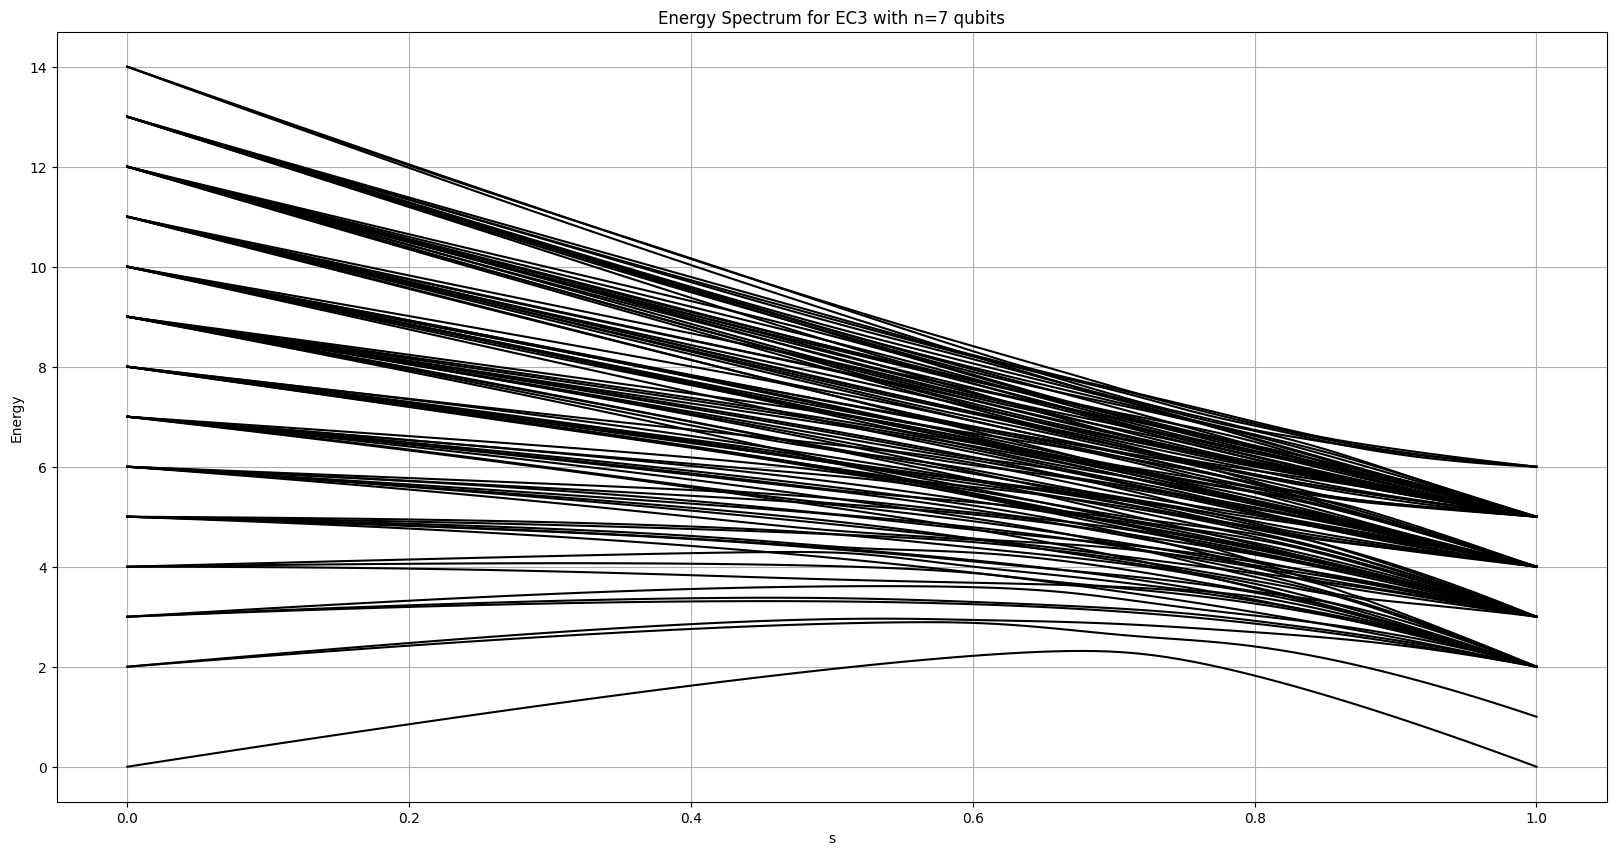

In [114]:
# Define single-qubit Pauli-X and Identity matrices
I = qeye(2)
I_7 = tensor([I for _ in range(n_qubits)])
X = sigmax()
Z = sigmaz()


def H_B(clauses):
    """Construct the beginning Hamiltonian H_B as per the paper for the given clauses."""
    H_b = 0
    for (i, j, k) in clauses:
        H_b += 0.5 * (I_7 - tensor([X if x == i else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == j else I for x in range(n_qubits)]))
        H_b += 0.5 * (I_7 - tensor([X if x == k else I for x in range(n_qubits)]))
    return H_b

def check_clause_violation(state_binary, clause):
    """Check if a clause (i, j, k) is violated by the given state."""
    i, j, k = clause
    bits = [state_binary[i], state_binary[j], state_binary[k]]
    return sum(bits) != 1

def cost_function(z, clauses):
    """Compute the cost function h(z), the number of violated clauses."""
    bitstring = f"{z:0{n_qubits}b}"
    bit_values = [int(b) for b in bitstring] 

    violations = 0
    # Check each clause for violation
    for clause in clauses:
        if check_clause_violation(bit_values, clause):
            violations += 1  # Clause is violated

    return violations

# Problem Hamiltonian H_P
def H_P(clauses):
    """Construct the problem Hamiltonian H_P as a diagonal operator."""
    H_p = 0
    # Loop over all possible basis states (bitstrings) z
    for z in range(2**n_qubits):
        state = basis(2**n_qubits, z)

        h_z = cost_function(z, clauses)
        projector_z = state * state.dag()
        
        H_p += h_z * projector_z
    return H_p


def H_t(s, args):
    Hb = H_B(clauses)
    Hp = H_P(clauses)
    Hb = Qobj(Hb.data, dims=Hp.dims)
    return (1 - s) * Hb + s * Hp


s_values = np.linspace(0, 1, 100)

# Calculate the energy spectrum
energy_spectrum = []
for s in s_values:
    H = H_t(s, None)
    energies = H.eigenenergies()
    energy_spectrum.append(energies)


energy_spectrum = np.array(energy_spectrum)

# Plot the energy spectrum
plt.figure(figsize=(20, 10))
for i in range(len(energy_spectrum)):
    plt.plot(s_values, energy_spectrum[:, i], color='black')

plt.xlabel('s')
plt.ylabel('Energy')
plt.title('Energy Spectrum for EC3 with n=7 qubits')
plt.grid(True)
plt.show()